# Next Word Prediction

In [1]:
import numpy as np

In [2]:
from nltk.tokenize import RegexpTokenizer

In [3]:
from tensorflow.keras.models import Sequential, load_model  # Modified import
from tensorflow.keras.layers import LSTM  # Modified import
from tensorflow.keras.layers import Dense, Activation  # Modified import
from tensorflow.keras.optimizers.legacy import Adam

In [4]:
import matplotlib.pyplot as plt
import pickle
import heapq

In [5]:
import requests

# url = r'https://raw.githubusercontent.com/simranjeet97/75DayHard_GenAI_LLM_Challenge/main/NextWordPrediction_DeepLearning/1661-0.txt'
url = r'https://raw.githubusercontent.com/anishadesai5/NextWordPrediction/refs/heads/main/1661-0.txt'

response = requests.get(url)

if response.status_code == 200:
    text = response.text.lower()
    print('corpus length:', len(text))
else:
    print(f"Error fetching file. Status code: {response.status_code}")

corpus length: 594199


In [6]:
# split the entire dataset into each word in order without the presence of special characters.
tokenizer = RegexpTokenizer(r'\w+')
words = tokenizer.tokenize(text)

In [7]:
words

['project',
 'gutenberg',
 's',
 'the',
 'adventures',
 'of',
 'sherlock',
 'holmes',
 'by',
 'arthur',
 'conan',
 'doyle',
 'this',
 'ebook',
 'is',
 'for',
 'the',
 'use',
 'of',
 'anyone',
 'anywhere',
 'at',
 'no',
 'cost',
 'and',
 'with',
 'almost',
 'no',
 'restrictions',
 'whatsoever',
 'you',
 'may',
 'copy',
 'it',
 'give',
 'it',
 'away',
 'or',
 're',
 'use',
 'it',
 'under',
 'the',
 'terms',
 'of',
 'the',
 'project',
 'gutenberg',
 'license',
 'included',
 'with',
 'this',
 'ebook',
 'or',
 'online',
 'at',
 'www',
 'gutenberg',
 'org',
 'title',
 'the',
 'adventures',
 'of',
 'sherlock',
 'holmes',
 'author',
 'arthur',
 'conan',
 'doyle',
 'release',
 'date',
 'november',
 '29',
 '2002',
 'ebook',
 '1661',
 'last',
 'updated',
 'may',
 '20',
 '2019',
 'language',
 'english',
 'character',
 'set',
 'encoding',
 'utf',
 '8',
 'start',
 'of',
 'this',
 'project',
 'gutenberg',
 'ebook',
 'the',
 'adventures',
 'of',
 'sherlock',
 'holmes',
 'produced',
 'by',
 'an',
 'ano

In [8]:
# dictionary with each word form the unique_words list as key and its corresponding position as value.
unique_words = np.unique(words)
unique_word_index = dict((c, i) for i, c in enumerate(unique_words))

In [9]:
unique_word_index

{'0': 0,
 '000': 1,
 '1': 2,
 '10': 3,
 '100': 4,
 '1000': 5,
 '10_s_': 6,
 '10th': 7,
 '11': 8,
 '117': 9,
 '120': 10,
 '12_s_': 11,
 '12th': 12,
 '14': 13,
 '140': 14,
 '15': 15,
 '150': 16,
 '1500': 17,
 '1661': 18,
 '16a': 19,
 '17': 20,
 '1846': 21,
 '1858': 22,
 '1869': 23,
 '1870': 24,
 '1878': 25,
 '1883': 26,
 '1884': 27,
 '1887': 28,
 '1888': 29,
 '1890': 30,
 '19th': 31,
 '1_s_': 32,
 '2': 33,
 '20': 34,
 '200': 35,
 '2001': 36,
 '2002': 37,
 '2019': 38,
 '220': 39,
 '221b': 40,
 '226': 41,
 '22nd': 42,
 '249': 43,
 '25': 44,
 '250': 45,
 '26': 46,
 '26_s_': 47,
 '27': 48,
 '270': 49,
 '29': 50,
 '2_s_': 51,
 '2nd': 52,
 '3': 53,
 '30': 54,
 '31': 55,
 '35': 56,
 '3rd': 57,
 '4': 58,
 '40': 59,
 '4000': 60,
 '421': 61,
 '4700': 62,
 '4_d_': 63,
 '4th': 64,
 '4½': 65,
 '5': 66,
 '50': 67,
 '501': 68,
 '596': 69,
 '6': 70,
 '60': 71,
 '6221541': 72,
 '64': 73,
 '6_d_': 74,
 '7': 75,
 '700': 76,
 '750': 77,
 '750175': 78,
 '77': 79,
 '7_s_': 80,
 '7th': 81,
 '8': 82,
 '801': 83

In [10]:
WORD_LENGTH = 5
prev_words = []
next_words = []
for i in range(len(words) - WORD_LENGTH):
    prev_words.append(words[i:i + WORD_LENGTH])
    next_words.append(words[i + WORD_LENGTH])
print(prev_words[0])
print(next_words[0])

['project', 'gutenberg', 's', 'the', 'adventures']
of


In [11]:
# create two numpy array X(for storing the features) and Y(for storing the corresponding label).
X = np.zeros((len(prev_words), WORD_LENGTH, len(unique_words)), dtype=bool)
Y = np.zeros((len(next_words), len(unique_words)), dtype=bool)

In [12]:
print(unique_word_index['new'])

4841


In [13]:
X[1,2,unique_word_index['new']]

False

In [14]:
# I iterate X and Y if the word is present then the corresponding position is made 1.
for i, each_words in enumerate(prev_words):
    for j, each_word in enumerate(each_words):
        X[i, j, unique_word_index[each_word]] = 1
    Y[i, unique_word_index[next_words[i]]] = 1

# LSTM Model 

In [15]:
from tensorflow.keras.optimizers import Adam

In [16]:
#  single-layer LSTM model with 128 neurons, a fully connected layer, and a softmax function for activation.
model = Sequential()
model.add(LSTM(128, input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

# Define the optimizer
optimizer = Adam(learning_rate=0.01)

# Compile the model with the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with Adam optimizer
history = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=5, shuffle=True).history

C:\Users\anish\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 116s 139ms/step - accuracy: 0.0683 - loss: 6.5530 - val_accuracy: 0.1020 - val_loss: 6.9641
Epoch 2/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 110s 135ms/step - accuracy: 0.1570 - loss: 5.0993 - val_accuracy: 0.1239 - val_loss: 6.9839
Epoch 3/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.2244 - loss: 4.2503 - val_accuracy: 0.1172 - val_loss: 7.3225
Epoch 4/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 130s 160ms/step - accuracy: 0.3453 - loss: 3.2066 - val_accuracy: 0.1124 - val_loss: 8.2021
Epoch 5/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 125s 155ms/step - accuracy: 0.5131 - loss: 2.2100 - val_accuracy: 0.1020 - val_loss: 9.1869


In [17]:
model.save('next_word_model.h5')
pickle.dump(history, open("history.p", "wb"))
model = load_model('next_word_model.h5')
history = pickle.load(open("history.p", "rb"))

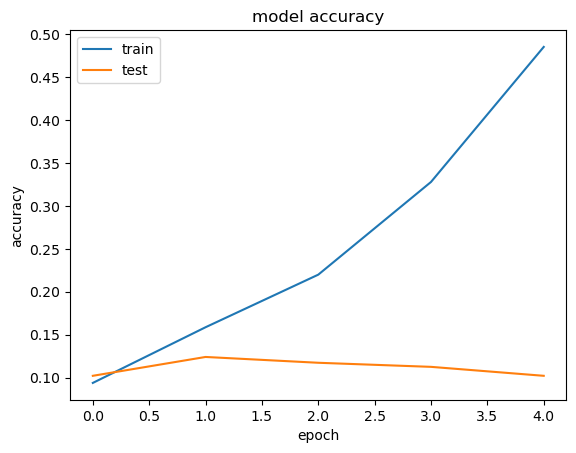

In [18]:
# Evaluating the model
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

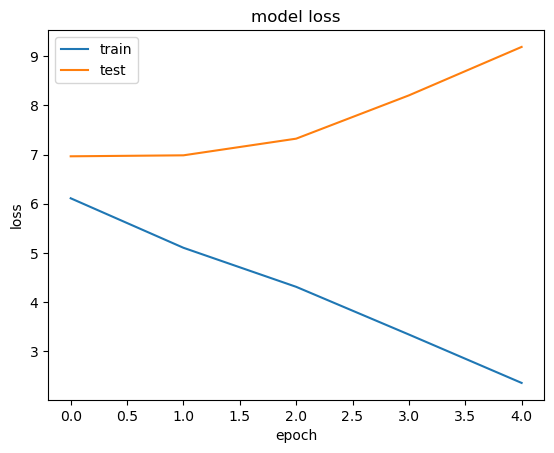

In [19]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [20]:
# Testing next word
def prepare_input(text):
    x = np.zeros((1, WORD_LENGTH, len(unique_words)))
    for t, word in enumerate(text.split()):
        print(word)
        x[0, t, unique_word_index[word]] = 1
    return x

prepare_input("It is not a lack".lower())

it
is
not
a
lack


array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [21]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

# I use the function predict_completions which use the model to predict and return the list of n predicted words.
def predict_completions_with_probabilities(text, n=3):
    if text == "":
        return [("0", 0.0)]  # Return a tuple containing a placeholder and probability 0.0
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    probabilities = [preds[idx] for idx in next_indices]
    predicted_words = [unique_words[idx] for idx in next_indices]
    return list(zip(predicted_words, probabilities))

# Your example
q = "Your life will never be there in the same situation again"
print("Correct sentence:", q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence:", seq)

# Get predictions with probabilities for each word in the sequence
predictions_with_probabilities = predict_completions_with_probabilities(seq, 5)

# Display predictions with probabilities
for word, probability in predictions_with_probabilities:
    print(f"Word: {word}, Probability: {probability * 100}")

Correct sentence: Your life will never be there in the same situation again
Sequence: your life will never be
your
life
will
never
be
Word: so, Probability: 34.25639867782593
Word: fruitless, Probability: 6.299818307161331
Word: any, Probability: 4.293378442525864
Word: allowed, Probability: 3.357664868235588
Word: wanting, Probability: 2.650662139058113


# LSTM Bidirectional Model

In [22]:
from tensorflow.keras.layers import LSTM, Dense, Activation, Bidirectional

# Define the bidirectional LSTM model
model = Sequential()
model.add(Bidirectional(LSTM(128), input_shape=(WORD_LENGTH, len(unique_words))))
model.add(Dense(len(unique_words)))
model.add(Activation('softmax'))

# Define the optimizer
optimizer = Adam(learning_rate=0.01)

# Compile the model with the Adam optimizer
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with the Adam optimizer
history_2 = model.fit(X, Y, validation_split=0.05, batch_size=128, epochs=5, shuffle=True).history

C:\Users\anish\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 216s 261ms/step - accuracy: 0.0750 - loss: 6.4474 - val_accuracy: 0.1106 - val_loss: 6.8739
Epoch 2/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 229s 282ms/step - accuracy: 0.1762 - loss: 4.8070 - val_accuracy: 0.1322 - val_loss: 6.9453
Epoch 3/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 216s 267ms/step - accuracy: 0.3047 - loss: 3.4588 - val_accuracy: 0.1183 - val_loss: 7.6592
Epoch 4/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 211s 261ms/step - accuracy: 0.5692 - loss: 1.8787 - val_accuracy: 0.1045 - val_loss: 8.8985
Epoch 5/5
811/811 ━━━━━━━━━━━━━━━━━━━━ 206s 255ms/step - accuracy: 0.7741 - loss: 0.9439 - val_accuracy: 0.0952 - val_loss: 10.1290


In [23]:
def sample(preds, top_n=3):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds)
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return heapq.nlargest(top_n, range(len(preds)), preds.take)

# I use the function predict_completions which use the model to predict and return the list of n predicted words.
def predict_completions_with_probabilities(text, n=3):
    if text == "":
        return [("0", 0.0)]  # Return a tuple containing a placeholder and probability 0.0
    x = prepare_input(text)
    preds = model.predict(x, verbose=0)[0]
    next_indices = sample(preds, n)
    probabilities = [preds[idx] for idx in next_indices]
    predicted_words = [unique_words[idx] for idx in next_indices]
    return list(zip(predicted_words, probabilities))

# Your example
q = "Your life will never be there in the same situation again"
print("Correct sentence:", q)
seq = " ".join(tokenizer.tokenize(q.lower())[0:5])
print("Sequence:", seq)

# Get predictions with probabilities for each word in the sequence
predictions_with_probabilities = predict_completions_with_probabilities(seq, 5)

# Display predictions with probabilities
for word, probability in predictions_with_probabilities:
    print(f"Word: {word}, Probability: {probability * 100}")

Correct sentence: Your life will never be there in the same situation again
Sequence: your life will never be
your
life
will
never
be
Word: of, Probability: 62.40759491920471
Word: some, Probability: 7.201064378023148
Word: more, Probability: 3.0295662581920624
Word: quite, Probability: 3.0277956277132034
Word: very, Probability: 1.7333664000034332


In [24]:
print("Unidirectional LSTM - Validation Accuracy:", history['val_accuracy'][-1]*100)
print("Bidirectional LSTM - Validation Accuracy:", history_2['val_accuracy'][-1]*100)

Unidirectional LSTM - Validation Accuracy: 10.197729617357254
Bidirectional LSTM - Validation Accuracy: 9.52032208442688
